<b>AML2019</b>

<h3>Challenge 3</h3>
<h1>Anomaly Detection (AD)</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>3<sup>th</sup> May 2019 - DESVIGNES Maïlys and JAY Mathilde</i>

<div class="alert alert-warning">
<ul>As suggested, this notebook go through the folowing steps:
    <li>Data Exploration And Pre-Processing</li>
    <ul>
        <li>Data Loading</li>
        <li>Visualisation</li>
        <li>Finding errors</li>
        <li>Handling NaN</li>
        <li>Correlation</li>
        <li>Normalization</li>
        <li>Standarization</li>
        </ul>
        <li>Model selection: Not Interpretable Models</li>
    <ul>
        <li>Unsupervised model : Isolation Forest</li>
        <li>Supervised model : Random Forest</li> </ul>
    <li>Model selection: Interpretable Models</li>
    <ul>
        <li>Bayesian Rule Sets</li>
        <li>Scalable Bayesian Rule Lists</li>
        </ul>
        </ul>
</ul> </div>

In [3]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import implicit

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pysbrl
from ruleset import *
import tqdm
from time import time

from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
from tqdm import tqdm
from time import time
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import StandardScaler

# Data Exploration And Pre-Processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

<div class="">
    <h3>Data Loading</h3>
</div>

In [4]:
features=['SessionNumber', 'SystemID', 'Date', 'HighPriorityAlerts', 'Dumps', 'CleanupOOMDumps', 'CompositeOOMDums', 'IndexServerRestarts', 'NameServerRestarts', 'XSEngineRestarts', 'PreprocessorRestarts', 'DaemonRestarts', 'StatisticsServerRestarts', 'CPU', 'PhysMEM', 'InstanceMEM', 'TablesAllocation', 'IndexServerAllocationLimit', 'ColumnUnloads', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', 'Disk', 'LargestTableSize', 'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 'DaysWithSuccessfulDataBackups', 'DaysWithSuccessfulLogBackups', 'DaysWithFailedDataBackups', 'DaysWithFailedfulLogBackups', 'MinDailyNumberOfSuccessfulDataBackups', 'MinDailyNumberOfSuccessfulLogBackups', 'MaxDailyNumberOfFailedDataBackups', 'MaxDailyNumberOfFailedLogBackups', 'LogSegmentChange', 'Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']
checks=['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']

In [5]:
os.listdir('/mnt/datasets/anomaly')
dataDF = pd.read_csv('/mnt/datasets/anomaly/data.csv', header=None,  names=features, sep=';')
dataDF[0:5]


,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,...,MaxDailyNumberOfFailedLogBackups,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,0,0,16/01/2017 04:04,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,1,1,06/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2,1,20/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,3,2,13/02/2017 04:44,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,4,3,06/02/2017 04:31,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [6]:
print(dataDF.shape)
dataDF.get_dtype_counts()

(287031, 44)


float64    25
int64      18
object      1
dtype: int64

<div class="alert alert-warning"> <p> We have a dataset of almost 300 000 samples, 8 labels and 36 features. The types of the features are almost all numbers, exept for the Date, which we should process. A first idea is to convert to seconds. But since the date is not really relevant (detecting an anomalie with exact data and hours doesn't make sense). Therefore, we will only keep the hour and convert it to minutes.</p> </div>  

In [7]:
def convert_to_min(date):
    return int(date[11:][:2])*60+int(date[14:])

In [8]:
df = dataDF['Date']
dataDF['Hour'] = df.apply(convert_to_min)
dataDF = dataDF.drop(columns=['Date'])

In [9]:
print(dataDF.shape)
dataDF.get_dtype_counts()

(287031, 44)


float64    25
int64      19
dtype: int64

<div class="alert alert-warning"><p> Yey! No objects anymore. </p></div>

<div class="">
    <h3>Visualization</h3>
</div>

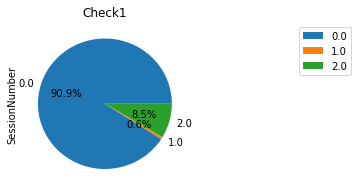

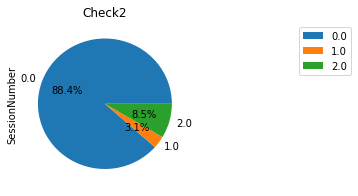

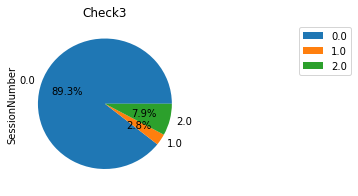

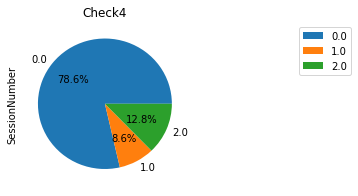

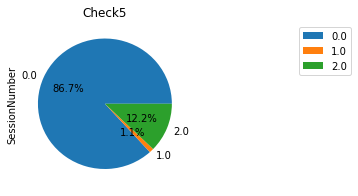

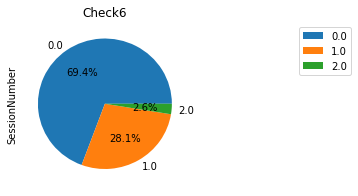

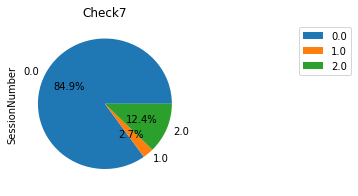

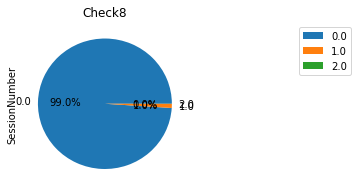

In [10]:
dataDF_count = dataDF.copy()
dataDF_count[checks] = dataDF_count[checks].fillna(2) #2 instead of Nan, so we can see the distribution

for check in checks:
    dataDF_count_i= dataDF_count[[check, 'SessionNumber']].groupby(check).count()
    plot = dataDF_count_i.plot.pie(y='SessionNumber',autopct='%1.1f%%', figsize=(3, 3),title = check)
    plot.get_legend().set_bbox_to_anchor((2, 1))


<div class="alert alert-warning">Except for check6, they are a very low proportion of alert. And for most of the check, they are more Nan than 1! </div>

<div class="">
    <h3>Finding errors</h3>
</div>

<div class="alert alert-warning"> Let's check if all samples are in their range. </div>

##### The features that might raise issues are:
* <i>CPU</i> (FLOAT [0, 100]): cpu usage;
* <i>PhysMEM</i> (FLOAT [0, 100]): physical memory;
* <i>InstanceMEM</i> (FLOAT [0, 100]): memory usage of one instance of the system;
* <i>TablesAllocation</i> (FLOAT [0, 100]): memory allocated for tables;
* <i>IndexServerAllocationLimit</i> (FLOAT [0, 100]): level of memory used by index server;
* <i>MergeErrors</i> BOOLEAN [0, 1]: 1 if there are merge errors;
* <i>Disk</i> (FLOAT [0, 100]): disk usage;

In [11]:
dataDF[['CPU','PhysMEM','InstanceMEM','TablesAllocation','IndexServerAllocationLimit','MergeErrors','Disk']].describe()

,CPU,PhysMEM,InstanceMEM,TablesAllocation,IndexServerAllocationLimit,MergeErrors,Disk
count,261822.000000,2.664640e+05,264914.000000,284741.000000,260587.000000,279298.000000,2.756520e+05
mean,12.504883,1.992282e+02,47.683065,23.243752,50.252361,0.416469,7.423645e+10
std,20.605688,1.522155e+04,23.960828,17.889126,27.338611,0.492974,4.357427e+12
min,0.120000,2.020000e+00,0.010000,0.000000,0.230000,0.000000,2.100000e-01
25%,2.950000,4.655000e+01,28.480000,8.630000,27.530000,0.000000,3.262000e+01
50%,6.460000,7.004000e+01,46.310000,20.490000,48.560000,0.000000,5.531000e+01
75%,14.900000,8.645000e+01,66.320000,35.000000,73.390000,1.000000,7.499000e+01
max,4602.490000,2.070680e+06,99.150000,94.600000,99.550000,1.000000,3.731038e+14


<div class="alert alert-warning"> It seems that the CPU usage, the physical memory and the disk usage are going out of their range. </div> 

In [12]:
print(dataDF[dataDF['CPU'] > 100].CPU.shape)
print(dataDF[dataDF['PhysMEM'] > 100].PhysMEM.shape)
print(dataDF[dataDF['Disk'] > 100].Disk.shape)

(9,)
(31,)
(188,)


<div class="alert alert-warning"> Fortunatly, it is only for few samples. So let's remove them.  </div>

In [13]:
dataDF = dataDF[dataDF['CPU'] <= 100]
dataDF = dataDF[dataDF['PhysMEM'] <= 100]
dataDF =dataDF[dataDF['Disk'] <= 100]

<div class="">
    <h3>Handling NaN</h3>
</div>

<div class="">
    <h4>Replacing the missing values</h4>
</div>

In [14]:
#Let's see how much missing values there are
total = dataDF.isnull().sum().sort_values(ascending=False)
percent = (dataDF.isnull().sum() / dataDF.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
BlockingPhaseSec,51864,0.201106
Check4,14909,0.057811
Check7,13646,0.052913
LogSegmentChange,13480,0.052270
Check5,13459,0.052188
LargestTableSize,13070,0.050680
DiagnosisFiles,12585,0.048799
DiagnosisFilesSize,12585,0.048799
MergeErrors,6198,0.024033
IndexServerAllocationLimit,5232,0.020287


<div class="alert alert-warning"> It seems like we have quite a lot of missing data, in all the checks espacially. This can't be given to a model so we should remove or replace them. For some checks we have 10% of missing information. It seems a reasonable assumption that no information means no alerts, and therefore put all Nan at 0. For the features, we start by putting all the missing values to the mean of the features. We will see that the features with the most missing values are some of the less correlated to the checks, so not going into more details on this will probably not have a big impact on the models performances. </div>

In [15]:
def fill_missing_values(inputDF):
    inputDF[checks] = inputDF[checks].fillna(0)
    total = inputDF.isnull().sum().sort_values(ascending=False)
    to_drop = list(total.where(total > 0).dropna().index)
    for col in to_drop:
        inputDF[col] = inputDF[col].fillna(np.mean(dataDF[col]))
    return inputDF

In [16]:
filled_dataDF = fill_missing_values(dataDF)

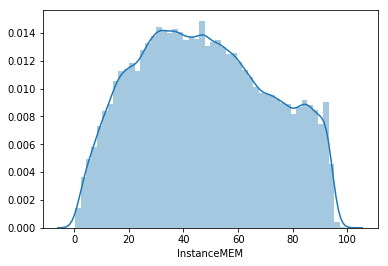

In [17]:
sns.distplot(filled_dataDF['InstanceMEM'])

<div class="alert alert-warning"> Due to the big difference in the distribution of the features, the choice of putting the Nan to the mean have different impacts. For example, it doesn't really impact the distribution of the feature 'InstanceMEM'. </div>

<div class="">
    <h4>Dropping the missing values</h4>
</div>

<div class="alert alert-warning">  As you went through the model evaluation, we realized that replacing the missing values as we were doing it was perhaps not the best idea. So we decided to create a dataset cleaned of all missing value. </div>

In [18]:
pure_dataDF = dataDF.dropna()
pure_dataDF.shape

(257894, 44)

<div class="alert alert-warning"> We lost 30 000 samples, which only represent 10 percent of the dataset.</div>

<div class="">
    <h3>Correlation</h3>
</div>

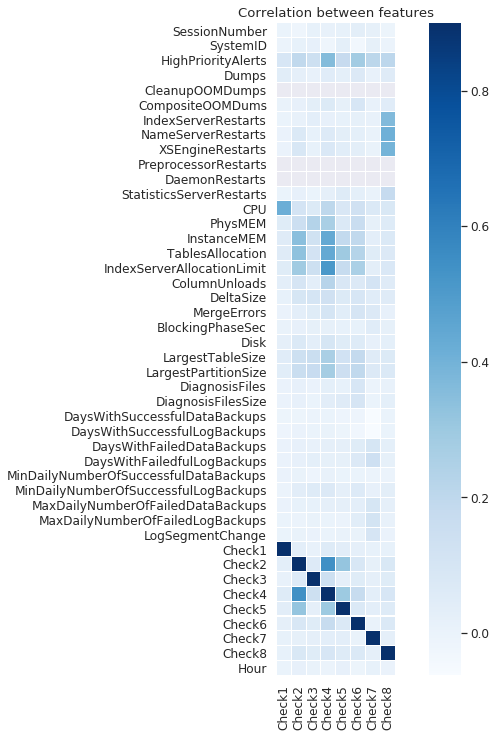

In [19]:
#matrix of correlation
checks=['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']

corrMatrix=pure_dataDF.corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(12, 12))
#sns.palplot(sns.color_palette("YlOrBr", 10))
sns.heatmap(corrMatrix[checks], vmax=.9, linewidths=0.01,
            square=True,annot=False,cmap='Blues',linecolor="white")
plt.title('Correlation between features');


<div class="alert alert-warning"> <p> First thing we can notice is that 3 columns are in grey - meaning that no correlation could be computed. Let's have a look at them.</p> </div>

In [20]:
pure_dataDF[['CleanupOOMDumps','PreprocessorRestarts','DaemonRestarts']].describe()

,CleanupOOMDumps,PreprocessorRestarts,DaemonRestarts
count,257894.0,257894.0,257894.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


<div class="alert alert-warning"> Those features are useless. </div>

In [21]:
pure_dataDF = pure_dataDF.drop(columns = ['CleanupOOMDumps','PreprocessorRestarts','DaemonRestarts'])
filled_dataDF = filled_dataDF.drop(columns = ['CleanupOOMDumps','PreprocessorRestarts','DaemonRestarts'])

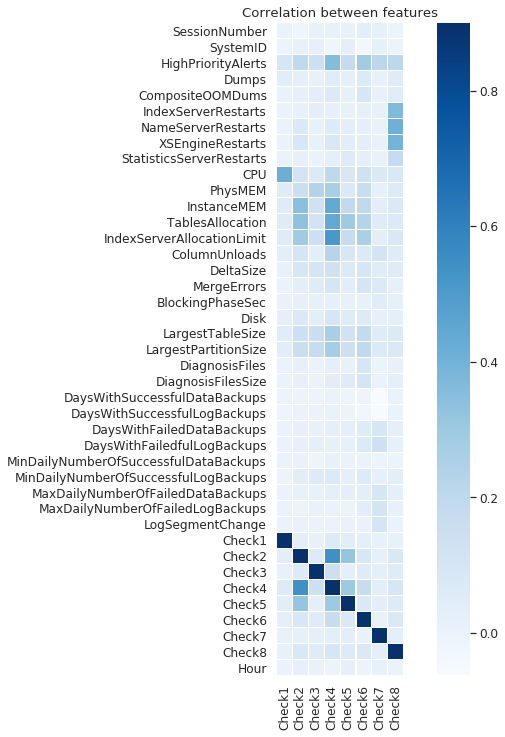

In [22]:
#matrix of correlation
checks=['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']

corrMatrix=pure_dataDF.corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(12, 12))
#sns.palplot(sns.color_palette("YlOrBr", 10))
sns.heatmap(corrMatrix[checks], vmax=.9, linewidths=0.01,
            square=True,annot=False,cmap='Blues',linecolor="white")
plt.title('Correlation between features');


In [23]:
#Let's find the most correlated columns with each check
MostCorrWithCheck = {}
for col in list(checks):
    for kol in corrMatrix[corrMatrix[col] > 0.2].index:
        if col not in MostCorrWithCheck.keys():
            MostCorrWithCheck[col]=[]
        if kol != col and kol not in MostCorrWithCheck[col]:
            MostCorrWithCheck[col].append(kol)
#MostCorrWithCheck = [list(x) for x in MostCorrWithCheck]
print('The columns with a correlation higher than 0.2 with each checks are: ')
MostCorrWithCheck

The columns with a correlation higher than 0.2 with each checks are: 


{'Check1': ['CPU'],
 'Check2': ['InstanceMEM',
  'TablesAllocation',
  'IndexServerAllocationLimit',
  'Check4',
  'Check5'],
 'Check3': ['PhysMEM'],
 'Check4': ['HighPriorityAlerts',
  'CPU',
  'PhysMEM',
  'InstanceMEM',
  'TablesAllocation',
  'IndexServerAllocationLimit',
  'ColumnUnloads',
  'LargestTableSize',
  'LargestPartitionSize',
  'Check2',
  'Check5'],
 'Check5': ['TablesAllocation', 'Check2', 'Check4'],
 'Check6': ['HighPriorityAlerts',
  'TablesAllocation',
  'IndexServerAllocationLimit'],
 'Check7': ['HighPriorityAlerts'],
 'Check8': ['HighPriorityAlerts',
  'IndexServerRestarts',
  'NameServerRestarts',
  'XSEngineRestarts']}

<div class="alert alert-warning"> <p>Some anomaly checks are easy to understand. The first check seems to detect CPU unusual usage for exmple, and check3 the memory usage.</p>
<p>To save time later, let's find the n most correlated features to each checks: </p> </div>

In [24]:
def get_mostCorrelatedF(check, n):
    return list(corrMatrix[[check]].drop(checks).sort_values(by=[check], ascending = False)[:n].index)

<div class="alert alert-warning"> Or all the features correlated to a check with more than a wanted threshold:</div>

In [25]:
def get_mostCorrelated_value(check, thres):
    mostCorrolatedFeatures=corrMatrix[[check]].drop(checks)
    mostCorrolatedFeatures=mostCorrolatedFeatures[mostCorrolatedFeatures[[check]]>=thres].dropna(how='any')
    return list(mostCorrolatedFeatures.index)

<div class="">
    <h3>Normalization</h3>
</div>

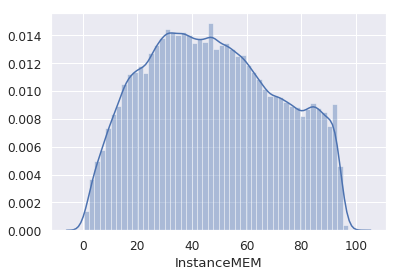

In [26]:
sns.distplot(pure_dataDF['InstanceMEM'])

In [27]:
from sklearn import preprocessing

dataDF_normalized = pure_dataDF.copy()

for col in pure_dataDF.columns :
    if col not in checks:
        x_array = np.array(pure_dataDF[col])
        dataDF_normalized[col] = preprocessing.normalize([x_array])[0]


In [28]:
pure_dataDF.describe()

,SessionNumber,SystemID,HighPriorityAlerts,Dumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,StatisticsServerRestarts,CPU,...,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8,Hour
count,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,...,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000,257894.000000
mean,121386.304517,618.110860,2.991632,0.711300,0.162830,0.101635,0.065108,0.058156,0.003947,12.478402,...,1.317298,0.006262,0.033556,0.030094,0.094481,0.011772,0.284004,0.028353,0.010877,392.095148
std,63903.731928,673.750398,2.670285,12.411868,1.765598,1.983365,1.247628,1.054824,0.089026,16.026193,...,115.169688,0.078886,0.180085,0.170846,0.292497,0.107860,0.450940,0.165979,0.103722,275.362007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,...,-16887.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67331.250000,101.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.950000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255.000000
50%,130167.500000,327.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.470000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,276.000000
75%,174643.000000,918.750000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.940000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,298.000000
max,228194.000000,3187.000000,24.000000,1429.000000,280.000000,341.000000,159.000000,150.000000,9.000000,100.000000,...,10084.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1439.000000


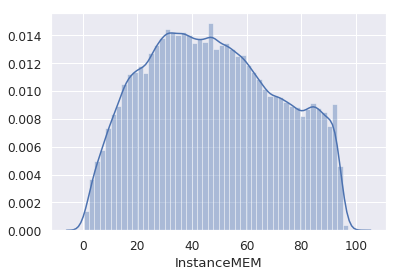

In [29]:
sns.distplot(pure_dataDF['InstanceMEM'])

<div class="alert alert-warning"> <p> Normalization put all values between 0 and 1 but doesn't change the distribution. It can really save time to reduce the range of the features. </p> </div>

<div class="">
    <h3>Standarization</h3>
</div>

In [30]:
featuresDF = dataDF_normalized.drop(columns = checks)
# Get column names first
names = featuresDF.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
scaled_featuresDF = scaler.fit_transform(featuresDF)
scaled_featuresDF = pd.DataFrame(scaled_featuresDF, columns=names)

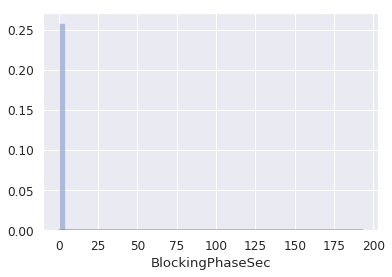

In [31]:
sns.distplot(scaled_featuresDF[names[17]])

# Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

<div class="alert alert-warning"><p> To select a model, we decided to test two different interpretable models, one classic supervised model to compare them with and finalyy a unsupervised model. Since not many interpretable models exist, we chose the easiest to implement: the Bayesian Rule Set and the Scalable Bayesian Rule Lists. As for the classic model, we went for a decision tree (random forest) for several reasons: it was really fast to train and similar to the interpretable models to the extent that the 'path of decision' can be understood. It does not give uncertainty estimates as the SBRL does but it gives really good total f1-score. As some checks give alerts at the time, we decided not to try a multi-label classification. </p></div>

<h4> IsolationForest (Unsupervised Model) </h4>


<div class="alert alert-warning"><p> We were interested in testing an unsupervised model to see if the anomalies were easily detectable. Indeed, that's why we used the Isolation Forest algorithm, which is a classification algorithm to detect outliers. We decided to select as features only the columns which has a correlation superior to 0.15 with each check  </p></div>

### Check1 ###
F1_score : 0.5909193591380154
Compilation time : 14.31114411354065
### Check2 ###
F1_score : 0.6146009924275218
Compilation time : 15.019053220748901
### Check3 ###
F1_score : 0.5463353387079963
Compilation time : 13.85899043083191
### Check4 ###
F1_score : 0.6533334221883538
Compilation time : 15.391858577728271
### Check5 ###
F1_score : 0.6554979874750594
Compilation time : 15.029347896575928
### Check6 ###
F1_score : 0.4999232947681319
Compilation time : 15.371532678604126
### Check7 ###
F1_score : 0.5758743053352902
Compilation time : 11.13041877746582
### Check8 ###
F1_score : 0.639910881402136
Compilation time : 13.222840547561646


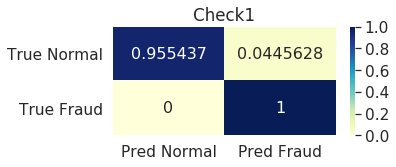

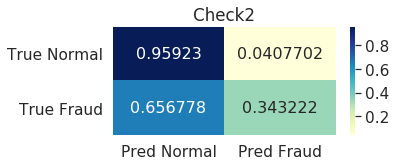

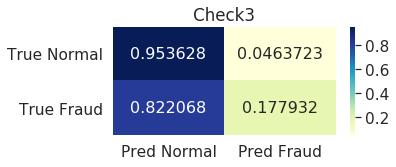

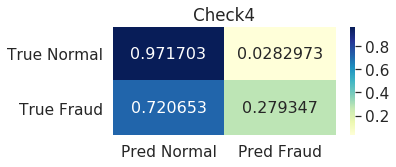

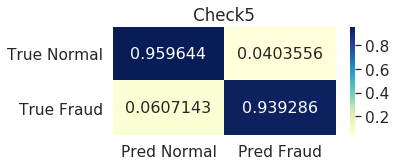

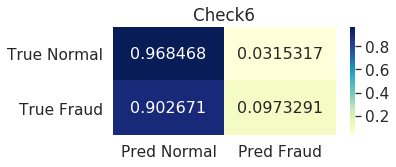

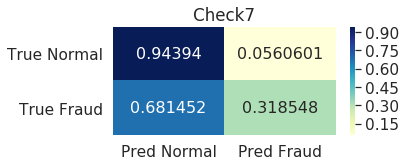

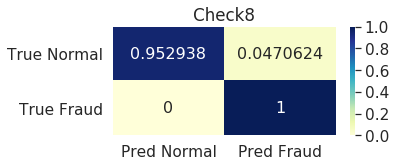

In [32]:
import time
for i in range (1,9):   
    
##### Dataset with only the correlated attributes of the checks #####
    check_number=str('Check'+str(i))
    X=dataDF_NanHandled[get_mostCorrelated_value(check_number, 0.15)]
    Y=dataDF_NanHandled[check_number]

##### Isolation Forest #####
    clf = IsolationForest(contamination=0.05)
    t0=time.time()
    clf.fit(X)
    #average_anomaly_score_test=clf.decision_function(X)
    pred_check = clf.predict(X)
    compilation_time=time.time()-t0
    
    pred_check=np.where(pred_check==1, 0, pred_check)
    pred_check=np.where(pred_check==-1, 1, pred_check)
    #average_anomaly_score2 = np.array([-1*s + .5 for s in average_anomaly_score])
    #np.percentile(average_anomaly_score2,[25,50,75])
    
    #accuracy=accuracy_score(Y_list, pred_check)
    print('###', check_number,'###' )
    print('F1_score :',f1_score(Y, pred_check, average='macro')) #,labels=[0,1]
    print('Compilation time :', compilation_time)
    
#####Plot confusion matrix ######
    osvm_cm=confusion_matrix(Y, pred_check)
    #print(osvm_cm)
    cm = osvm_cm.astype('float')/ osvm_cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (5,2)) #figsize = (5,2)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap="YlGnBu", fmt='g')# font size
    plt.title(check_number)   

<div class="alert alert-warning">  
<p> We can notice that the score is quite bad (in total: 0.589) and is worst as the number of features decreases. For instance, for the first check, as we only consider the CPU columns, our IsolationForest algorithm detects all the marginal values, which are not always outliers and so anomaly. What we could do is to let add more attributes for each checks. However the computation time would increase.</p>
<p> The other problem with this algorithm is that we need to define a proportion of outliers, and this proportion depends for each check: it's around 3% except for check 6 where it's about 28%. The algorithm will select all marginal samples until the manually defined proportion is reached. </p>  
</div>

<h4> Supervised model </h4>

<p> As we were having labels for our samples with the checks, it was useless to continue with unsupervised models. Especially that they were not giving good results. </p> 
<p> The fisrt supervised model we tried was the Support Vector Machines, however the computation time to train it was superior to 20minutes for only 100 samples, giving really poor estimation results. That's why, we decided to stop our try on this model and decided to do decision trees again: </p>

<h4> RandomForest (Supervised Model) </h4>

In [95]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

### Check1 ###
f1_score : 0.970619150689634
Training time : 0.8446447849273682
### Check2 ###
f1_score : 0.977241023385045
Training time : 1.875307321548462
### Check3 ###
f1_score : 0.7256736970475458
Training time : 9.989158391952515
### Check4 ###
f1_score : 0.9813616139180937
Training time : 4.538025140762329
### Check5 ###
f1_score : 0.9626174672175147
Training time : 7.471731424331665
### Check6 ###
f1_score : 0.8497100492097449
Training time : 21.59860920906067
### Check7 ###
f1_score : 0.4951275381416187
Training time : 0.36179351806640625
### Check8 ###
f1_score : 0.99931268791819
Training time : 0.5194578170776367


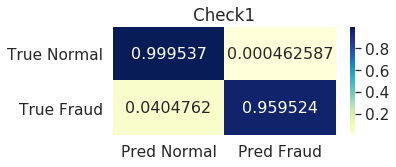

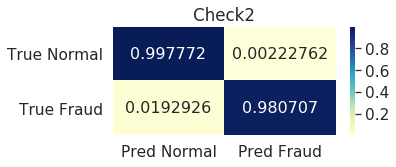

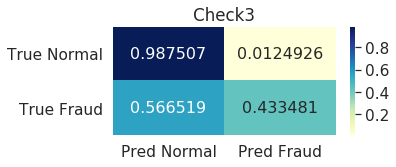

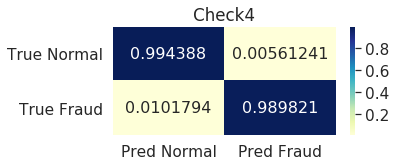

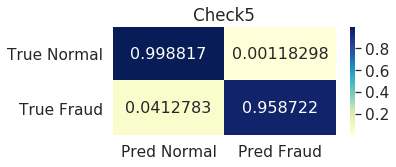

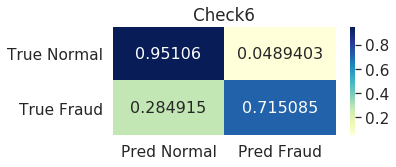

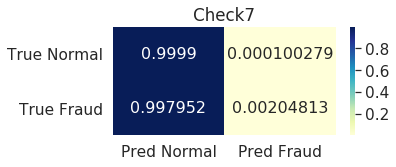

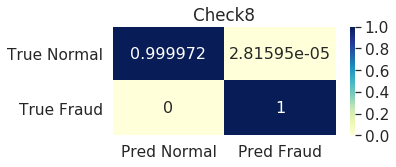

In [220]:
for i in range (1,9):   
    
##### Dataset with only the correlated attributes of the checks #####
    check_number=str('Check'+str(i))
    corrolated_attributes=get_mostCorrelated_value(check_number, 0.15)
    x_train_1=x_train[corrolated_attributes]
    x_test_1=x_test[corrolated_attributes]
    y_train_1=y_train[check_number]
    y_test_1=y_test[check_number]

##### Random Forest #####
    regressor = RandomForestRegressor(n_estimators=20, random_state=0) 
    t0=time.time()
    regressor.fit(x_train_1, y_train_1)  
    deltat=time.time()-t0
    y_pred = regressor.predict(x_test_1) 
    y_pred=y_pred.round()

    print('###', check_number,'###' )
    print('f1_score :',f1_score(y_test_1,y_pred, average='macro'))
    print('Training time :', deltat)
    
#####Plot confusion matrix ######
    osvm_cm=confusion_matrix(y_test_1, y_pred)
    #print(osvm_cm)

    cm = osvm_cm.astype('float') / osvm_cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (5,2)) 
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap="YlGnBu", fmt='g')# font size
    plt.title(check_number)

<div class="alert alert-warning">  <p> Compared to the unsupervised decision tree model (isolation forest), this model is very efficient: 0.87 of f1-score in total. Indeed, the computation time is very short and the accuracy really good except for test 3,6 and 7. Let's see if we can tune the parameters to get better results for these checks, and in general 
 </p> </div>

<h5> Paramaters tuning </h5>

In [ ]:

import scipy.stats
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters
hyperparameters = {
    'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 5)], 
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(1, 10, num = 5)],
    'bootstrap': [True, False]}

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

In [ ]:
resultsDF = pd.DataFrame(columns=['n_estimators', 'bootstrap','max_features','max_depth','check','time','f1_score'])

In [38]:
for i in tqdm(range(1,9)):
    check, x_train_check, x_test_check, y_train_check, y_test_check = get_correlated_columns(i,MostCorrWithCheck, x_train, x_test, y_train, y_test)

    for parameter_combination in parameter_grid:    
        model =  RandomForestRegressor(n_estimators= parameter_combination['n_estimators'],
                                   bootstrap = parameter_combination['bootstrap'],
                                   max_depth = parameter_combination['max_depth'],
                                   max_features = parameter_combination['max_features'])
        
        t0=time.time()
        model.fit(x_train_check, y_train_check)
        t1=time.time()-t0
        y_pred = model.predict(x_test_check) 
        y_pred=y_pred.round()
        accuracy=accuracy_score(y_test_check, y_pred)
    

        parameter_combination['check']=check
        parameter_combination['time']=t1
        parameter_combination['f1_score']=f1_score(y_test_check,y_pred, average='macro')
    
        resultsDF = resultsDF.append(parameter_combination,  ignore_index=True)



100%|██████████| 8/8 [17:09<00:00, 105.27s/it]


In [39]:
for i in range(1,9):
    check='Check'+str(i)
    resultsDF_sort1=resultsDF[resultsDF['check'] == check].sort_values(by =['f1_score'],ascending=False)
    print("###", check, "###")
    display(resultsDF_sort1[:3])

### Check1 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
22,10,True,auto,5,Check1,0.408631,0.977679
28,15,True,sqrt,5,Check1,0.483637,0.977679
33,15,True,auto,7,Check1,0.599977,0.977679


### Check2 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
198,15,False,sqrt,10,Check2,1.524471,0.975879
148,15,True,sqrt,10,Check2,1.152562,0.975249
144,20,True,auto,10,Check2,1.799237,0.975186


### Check3 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
240,1,True,auto,10,Check3,0.306884,0.574882
245,1,True,sqrt,10,Check3,0.190472,0.571066
294,20,False,auto,10,Check3,9.089821,0.568299


### Check4 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
396,5,False,sqrt,10,Check4,0.659101,0.972701
342,10,True,auto,10,Check4,2.090955,0.972636
343,15,True,auto,10,Check4,3.065722,0.972100


### Check5 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
442,10,True,auto,10,Check5,3.829209,0.962303
499,20,False,sqrt,10,Check5,5.056502,0.962100
444,20,True,auto,10,Check5,7.876116,0.962100


### Check6 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
541,5,True,auto,10,Check6,3.206728,0.625287
542,10,True,auto,10,Check6,6.156853,0.624210
543,15,True,auto,10,Check6,8.885569,0.624120


### Check7 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
620,1,True,auto,5,Check7,0.018780,0.498664
625,1,True,sqrt,5,Check7,0.018040,0.497691
630,1,True,auto,7,Check7,0.019238,0.497673


### Check8 ###


,n_estimators,bootstrap,max_features,max_depth,check,time,f1_score
723,15,True,auto,5,Check8,0.385509,0.999313
730,1,True,auto,7,Check8,0.027290,0.999313
745,1,True,sqrt,10,Check8,0.019404,0.999313


<div class="alert alert-warning"><p>  First of all, we observe that even with tuning, the score are similar to those without tuning. Tuning hasn't solved our issue with checks 3,6 and 7. However it has improved our score for the other checks.
For check 7, the score is still around 0.5 which shows that there is an issue with anomaly not detected, which can be explained by the small number of anomaly samples in our training set </p>
<p> Let's try interpretable models to see if they can solve our issues
</div>

In [30]:
#!pip3 install --user fim
#!pip3 install --user pysbrl
#!pip3 install --user ruleset
#!pip3 install --user mdlp
#!pip3 install --user mdlp-discretization
#!pip3 install --user skope-rules

<div class="">
    <h3>Bayesian Rule Sets</h3>
</div>

<div class="alert alert-warning"><p> The first interpretable model we implemented was BRS because it was the easiest to run. One thing there is to mention about this model is that there is no hyper parameters, therefore it is hard to control the time of computation which is quite long for this model. The only thing we could do to reduce the time was to take smaller datasets and do cross validation to be able to have trustworthy results. Unfortunatly, the more we reduce the bigger the probabilty to have no alert in the target set is. So, for sometimes half the time, we got an f1 score of 0. </p></div>

In [69]:
def BRS(df,check,resultsDF,*size):
    '''
    BRS for a given check
    append the results to the resultsDF = pd.DataFrame(columns=['Check', 'DataSetSize', 'ComputationTime','Confusion','f1score']) 
    size lengh 0 if want the whole data set, otherwise the size wanted
    
    '''
    X=df.drop(columns=checks)
    Y=df[check].values.astype('int64', copy=False)
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25)

    #Bayesian Rule Sets
    #Nn other format than numerical data and string
    model = BayesianRuleSet(method='forest')
    
    if len(size)==0:
        ''' want the whole dataset'''
        size = len(Y)
        t0 = time.time()
        model.fit(x_train, y_train)
        t1 = time.time() - t0
    else:
        t0 = time.time()
        model.fit(x_train[:size[0]], y_train[:size[0]])
        t1 = time.time() - t0
    
    yhat = model.predict(x_test)
    #get results
    TP, FP, TN, FN = get_confusion(yhat, y_test)
    F1 = f1_score(y_test, yhat)
    
    resultsDF = resultsDF.append({'Check':check, 'DataSetSize':size, 'ComputationTime':t1,'Confusion':[TP, FP, TN, FN],'f1score':F1}, ignore_index=True)
    return resultsDF

In [ ]:
resultsDF = pd.DataFrame(columns=['Check', 'DataSetSize', 'ComputationTime','Confusion','f1score'])
for x in range(5):
    checks=['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']
    for check in checks:
        print('###############' + check + '###################')
        resultsDF = BRS(dataDF_NanHandled,check,resultsDF,2500)

In [72]:
#So we can use the results during the next session
resultsDF.to_csv('resultsDF_first_try.csv')

<div class="alert alert-warning">To save space, let's only keep the rules for one run on check3. This is an other issue of the model: we can only get the interpretable rules when the model has been run and print them. We cannot save the model and get them whenever we need them. Also, with only 2500 samples, we have only few alert and the accuracy is high on the training set. However it is not enough to generalize well, and it already quite long to train.</div>

For Check3: 4th and last set of rules:

** chain = 1, max at iter = 85 ** 
 accuracy = 0.988, TP = 61,FP = 26, TN = 2409, FN = 4
 old is -163.64946892403387, pt_new is -159.65047284846605, prior_ChsRules=-54.89099469408393, likelihood_1 = -73.40052116793436, likelihood_2 = -31.358956986447765
 
['95.04<=PhysMEM', '53.95<=IndexServerAllocationLimit', 'IndexServerAllocationLimit<93.47', '0<=MinDailyNumberOfSuccessfulLogBackups']
['95.04<=PhysMEM', '2<=HighPriorityAlerts', 'HighPriorityAlerts<14', 'Date_09/10/2017 04:00_neg']
[553, 1595]

<div class="alert alert-warning"><p> For the first try, the only pre-processing we did were putting the NaN to 0 for the checks and to the mean for the other features. However the results are quite understandable and correspond to what we discovered with the correlation. Let's now look at the scores.
    </p></div>

In [35]:
#To get them back 
resultsDF_BRS = pd.read_csv('resultsDF_first_try.csv', sep=',').drop(columns=['Unnamed: 0'])
resultsDF_BRS.get_dtype_counts()

float64    2
object     3
dtype: int64

In [36]:
#process the dataframe to be able to use it 

#For the DataSetSize
def convert_to_int(tupl):
    return int(tupl[1:-2])

df = resultsDF_BRS['DataSetSize']
resultsDF_BRS['Size'] = df.apply(convert_to_int)
resultsDF_BRS = resultsDF_BRS.drop(columns=['DataSetSize'])

#For the confusion elements
def convert_confusion(string):
    t = string[1:-1].split(',')
    for i in range(len(t)):
        t[i] = int(t[i])
    return t

df = resultsDF_BRS['Confusion']
resultsDF_BRS['confusion'] = df.apply(convert_confusion)
resultsDF_BRS = resultsDF_BRS.drop(columns=['Confusion'])

In [40]:
resultsDF_BRS[resultsDF_BRS['Check'] == 'Check6']

,Check,ComputationTime,f1score,Size,confusion
5,Check6,4060.860078,0.953795,5000,"[19951, 1699, 49874, 234]"
17,Check6,199.900866,0.949145,2500,"[19765, 1871, 49875, 247]"
25,Check6,129.038418,0.947819,2500,"[19817, 1848, 49759, 334]"
33,Check6,216.638860,0.951621,2500,"[19975, 1802, 49752, 229]"
41,Check6,257.420311,0.936709,2500,"[19218, 1773, 49943, 824]"
49,Check6,268.509305,0.951210,2500,"[19837, 1790, 49886, 245]"


<div class="alert alert-warning">The resutls on check 6 are quite good, which is not surprizing since it is the check with the biggest proportion of alerts in the dataset. But the the time of computation is exploding when the dataset size is doubled so we can not use this model on the whole dataset. </div> 

In [42]:
resultsDF_BRS[resultsDF_BRS['Check'] == 'Check1'][resultsDF_BRS['Size'] == 2500]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Check,ComputationTime,f1score,Size,confusion
12,Check1,20.257875,0.000000,2500,"[0, 3, 71311, 444]"
20,Check1,22.725036,0.000000,2500,"[0, 0, 71350, 408]"
28,Check1,23.661012,0.000000,2500,"[0, 5, 71374, 379]"
36,Check1,23.263696,0.000000,2500,"[0, 0, 71293, 465]"
44,Check1,23.101047,0.945882,2500,"[402, 28, 71310, 18]"


<div class="alert alert-warning">As we said earlier, for most of the runs and with 2500 samples, it is very likely to have no alerts in the dataset. </div>

In [38]:
analysis = resultsDF_BRS[resultsDF_BRS['Size'] == 2500][['Check','f1score']].groupby('Check').max()
#analysis_0 = resultsDF_analysis[resultsDF_analysis['Size'] == 2500][resultsDF_analysis['f1score'] == 0].groupby('Check').count()
print('The final F1 score is: '+str(np.mean(analysis.f1score)))
#print(analysis_0)
analysis

The final F1 score is: 0.579170287890865


,f1score
Check,
Check1,0.945882
Check2,0.449420
Check3,0.811506
Check4,0.944641
Check5,0.000000
Check6,0.951621
Check7,0.514200
Check8,0.016092


<div class="alert alert-warning">It can be seen that even by taking the best results for each check, we still have a low total score. We could try to combine some checks to increase this. Of course we could increase the size of the dataset, as we can see below it always improve the results. But the time of computation is still random and make the training hard to do.</div>

In [57]:
analysis = resultsDF_BRS.groupby('Size').mean()
analysis

,ComputationTime,f1score
Size,,
1000,12.353156,0.000000
2500,49.474104,0.402185
5000,635.464540,0.499157
10000,366.328627,0.582328


<div class="">
    <h3>Scalable Bayesian Rule Lists </h3>
</div>

<div class="alert alert-warning">The difference in the implementation between the BRS and the SBRS is the discretisation of the features. So to get the rules, there is an additionnal step to do to get the intervals but this model is much more convienient to use. As for the performances, firstly the time of computation is way less random and is between 20min and 1h30 on the whole dataset. The f1-score seems to be quite good, however few checks don't give good results, especially check6. </div>

In [35]:
from pysbrl.train import train_sbrl
from pysbrl.rule_list import Clause, Rule, BayesianRuleList
from mdlp.discretization import MDLP
import pickle

In [36]:
def compute_intervals(mdlp_discretizer):
    category_names = []
    for i, cut_points in enumerate(mdlp_discretizer.cut_points_):
        idxs = np.arange(len(cut_points) + 1)
        names = mdlp_discretizer.assign_intervals(idxs, i)
        category_names.append(names)
    return category_names

In [82]:
def sbrl(inputDF,check_nb,features_nb,resDF,size,random_seed ):
    '''
    inputDF: DF 
    check_nb: target
    features_nb: nb of the most correlated features to train the model on
    resDF: result DF pd.DataFrame(columns=['Check', 'ComputationTime','f1score','features_nb','DataSetSize']) 
    size: size of dataset to train the model on
    '''
    #Select data
    check = 'Check'+str(check_nb)
    selected_features = get_mostCorrelatedF(check, features_nb)
    X=inputDF[selected_features]
    Y=np.array(dataDF[check].values.astype('int64', copy=False))
    
    if size == 'all':
        x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=random_seed)
    else:
        x_train, x_test, y_train, y_test = train_test_split(X[:size],Y[:size], test_size=0.25, random_state=random_seed)

    #discretize the data
    t0= time()
    discretizer = MDLP().fit(x_train, y_train)
    x_train_cat = discretizer.transform(x_train)
    t1 = time() - t0

    #build the model
    feature_names = list(x_train.columns)
    category_names = compute_intervals(discretizer)
    rule_list = BayesianRuleList(seed=1, feature_names=feature_names, category_names=category_names) #, verbose=2)

    #train the model
    t0= time()
    rule_list.fit(x_train_cat, y_train)
    dt = time() - t0
    rule_list._print(feature_names=feature_names)
    
    #make predictions
    x_test_cat = discretizer.transform(x_test)
    y_pred = rule_list.predict(x_test_cat)

    #Compute score and save the results
    F1 = f1_score(y_test, y_pred)
    resDF = resDF.append({'Check':check, 'ComputationTime':dt,'f1score':F1,'features_nb':features_nb,'DataSetSize':size,'discretizerTime':t1}, ignore_index=True)
    
    # save the model to disk
    filename = 'dropNan_modelcheck' + str(check_nb) + '.sav'
    pickle.dump(rule_list, open(filename, 'wb'))
    
    return resDF

<div class="alert alert-warning">To evaluate this model, we ran this function for different checks for different number of features, different dataset size, random seed and different inputDF (standarized or/and normalized).</div>

In [ ]:
#Find best parameters
#optim_SBRL = pd.read_csv('results_SBRL_scaledandnorm.csv', sep=',').drop(columns=['Unnamed: 0'])
optim_SBRL = pd.DataFrame(columns=['Check', 'ComputationTime','f1score','features_nb','DataSetSize','discretizerTime']) 
size = 'all'
inputDF = scaled_featuresDF
features_nb = 5
random_seed = 15
for check_nb in tqdm(range(1,9)):
    optim_SBRL = sbrl(inputDF,check_nb,features_nb,optim_SBRL,size,random_seed)

In [ ]:
optim_SBRL.to_csv('SBRL.csv')

In [47]:
#Analysis of the impact of normalization and of the number of features used
check1_SBRL = pd.read_csv('check1_SBRL.csv', sep=',').drop(columns=['Unnamed: 0'])
check1_SBRL.sort_values(by='DataSetSize')[check1_SBRL['DataSetSize']=='all']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Check,ComputationTime,f1score,features_nb,DataSetSize,discretizerTime
0,Check1,592.945876,0.964591,3,all,10.019336
1,Check1,863.666578,0.971286,10,all,41.062548
10,Norm_check1,312.447982,0.964591,5,all,12.482558
11,Norm_check1,333.801245,0.958580,5,all,12.483571


<div class="alert alert-warning"> It seems that the normalization operation really reduces the time of computation. One strange thing is that the model has better performance with less data, but we should run this on different datasets to avoid overfitting. </div>

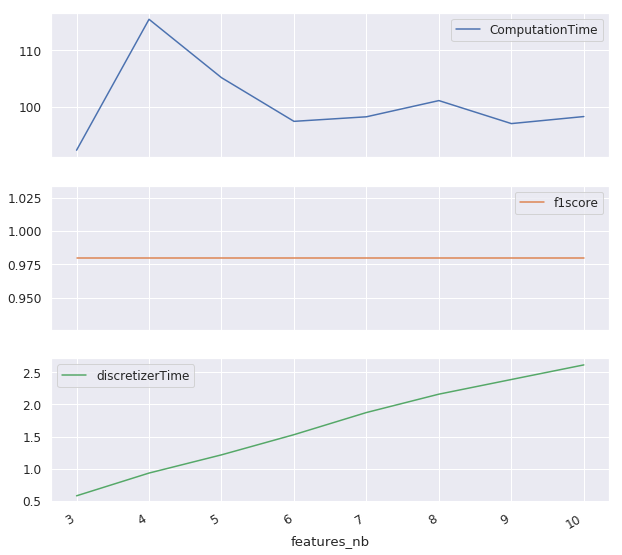

In [57]:
lines = check1_SBRL[check1_SBRL['DataSetSize'] == '50000'].plot.line(subplots=True,x = 'features_nb',figsize = (10,10))

<div class="alert alert-warning"> How many columns should we use?
<ul> <li>The less the easier to understand</li>
    <li> But the more information is lost </li> </ul>
It seems like only the time of discretization really change for check1, but it should not be the same for every check and perhaps we should adapt the number of columns to each check. However, this confirms that we don't need to use a lot of features to predict check1.</div>


<div class="alert alert-warning">Let's analyse the score of the model on each check. </div>

In [69]:
res = pd.read_csv('SBRL.csv', sep=',').drop(columns=['Unnamed: 0'])

def convert_to_int(tupl):
    return int(tupl[-1])

df = res['Check']
res['Check_nb'] = df.apply(convert_to_int)
res = res.drop(columns=['Check']) 
res = res.sort_values(by='Check_nb').reset_index()

The final f1-score is: 0.7942661072243788


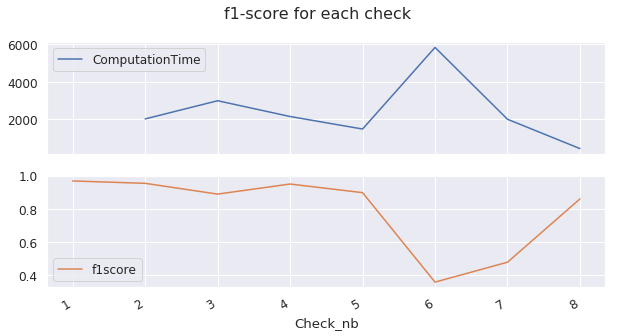

In [80]:
print('The final f1-score is: '+str(res['f1score'].mean()))
lines2 = res.plot.line(subplots=True,x = 'Check_nb',y=['ComputationTime','f1score'],figsize = (10,5),title='f1-score for each check')

<div class="alert alert-warning"> The first thing there is to say is that the scores are very different from one check to another. On the Check6 in particular, the score is very low and the computation is the longest, when it is the check with the biggest proportion of alerts in the dataset. Maybe this can be understood that check6 is not really an anomaly anymore, since it append for 30 percent of the sample! But our model isn't suited to anomaly detection so it doesn't really make sens.</div>

<div class="alert alert-warning">  Let's see the interpretable rules: </div>

In [81]:
# load the model from disk
filename = 'dropNan_modelcheck' + str(1) + '.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model._print(feature_names=feature_names)

The rule list contains 5 of rules:

     IF (TablesAllocation = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (HighPriorityAlerts = 0) THEN prob: [0.0411, 0.9589]

ELSE IF (IndexServerAllocationLimit = 2) AND (LargestPartitionSize = 1) THEN prob: [0.8333, 0.1667]

ELSE IF (InstanceMEM = 5) THEN prob: [0.1614, 0.8386]

ELSE DEFAULT prob: [0.0307, 0.9693]



In [46]:
# load the model from disk
filename = 'dropNan_modelcheck' + str(3) + '.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model._print(feature_names=feature_names)

The rule list contains 32 of rules:

     IF (TablesAllocation = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (InstanceMEM = 20) AND (HighPriorityAlerts = 17) THEN prob: [0.5060, 0.4940]

ELSE IF (InstanceMEM = 11) AND (HighPriorityAlerts = 20) THEN prob: [0.2184, 0.7816]

ELSE IF (InstanceMEM = 4) AND (HighPriorityAlerts = 15) THEN prob: [0.0312, 0.9688]

ELSE IF (HighPriorityAlerts = 17) AND (IndexServerAllocationLimit = 0) THEN prob: [0.0553, 0.9447]

ELSE IF (TablesAllocation = 3) AND (IndexServerAllocationLimit = 1) THEN prob: [0.0636, 0.9364]

ELSE IF (TablesAllocation = 3) AND (HighPriorityAlerts = 17) THEN prob: [0.4649, 0.5351]

ELSE IF (InstanceMEM = 10) THEN prob: [0.0983, 0.9017]

ELSE IF (InstanceMEM = 17) AND (HighPriorityAlerts = 17) THEN prob: [0.6048, 0.3952]

ELSE IF (InstanceMEM = 14) THEN prob: [0.1047, 0.8953]

ELSE IF (HighPriorityAlerts = 20) AND (IndexServerAllocationLimit = 3) THEN prob: [0.4962, 0.5038]

ELSE IF (InstanceMEM = 5) AND (IndexServerAllocationLimit = 1

<div class="alert alert-warning">  For some, the rules are really understandable and short, but others are more complexe. </div>

<div class="alert alert-warning">  <p>To conclude, we have seen two interpretable models, both with issues and never as good as a classic model. They had differents performances but for both the time of computation was really high, making preformance on the whole dataset hard to get. Also, the lack of hyperparameters makes them hard to adapt to our dataset. Their performances on each checks are not constants. We would however chose the second model (Scalable Bayesian Rule List) to predict alerts. Even though it was really bad for check 6, the first model is too long to compute.</p>
<p>As for the pre-processing, we noticed that normalizing and standardizing the data reduced the time of computation. Also, dropping samples instead of replacing the missing values by the mean or by 0 didn't improve the prediction. Even though we didn't plot the dataframe of results, we did trained the models.</p>
<p>To improve our model, we would have like to do cross-validation to check the stability of the scores, even if we did try few checks with different random seed.  Also, combining some checks, for example the 2,4 and 5 which ere highly correlated, could have saved time.</p></div>